In [1]:
import duckdb
import sqlite3
import os
import glob


In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']

In [ ]:
base_path = "/home/ehrhart/ecladatta/wikidata/parquet/external_reference_snaks" # put the path for the external snak (full july , 2025 dump filtered on P248 'stated in' and P854 'reference URL' properties )
con = duckdb.connect("wikidata.duckdb")

# Test Query

In [ ]:
# Create a view across all parquet files
# con.execute("""
#     CREATE VIEW ext AS 
#     SELECT * 
#     FROM '/home/ehrhart/ecladatta/wikidata/parquet/external_reference_snaks/*/*/*.parquet'
# """)

In [6]:
result = con.execute("SELECT COUNT(*) FROM ext").fetchall()


In [7]:
print(result)

[(1873671213,)]


In [8]:
con.execute("SELECT * FROM ext LIMIT 1").df()


,item_id,statement_guid,statement_value,statement_value_type,rank,ref_index,ref_hash,ref_value,ref_value_type,ref_property,statement_property
0,Q24957710,Q24957710$5250f380-430e-14a3-729f-5bf6ae971118,Церемония вступления Владимира Путина в должно...,string,normal,1,a079429fd78fa78234997dba9533538192a24fdd,Q14578684,wikibase-entityid,P248,P10


In [ ]:
# # claims
# con.execute("""
# CREATE OR REPLACE VIEW claims AS
# SELECT 
#     item_id AS entity_id,
#     statement_guid AS claim_id,
#     rank AS claim_rank,
#     statement_property AS property_id,
#     statement_value_type AS datatype,
#     statement_value AS datavalue
# FROM ext
# """)

# # claims_refs
# con.execute("""
# CREATE OR REPLACE VIEW claims_refs AS
# SELECT 
#     statement_guid AS claim_id,
#     ref_hash AS reference_id
# FROM ext
# """)

# # refs
# con.execute("""
# CREATE OR REPLACE VIEW refs AS
# SELECT 
#     ref_hash AS reference_id,
#     ref_property AS reference_property_id,
#     ref_index AS reference_index,
#     ref_value_type AS reference_datatype,
#     ref_value AS reference_value
# FROM ext
# """)


## Total count of claims and references

In [ ]:
# Count distinct claim_id
total_count_claims = con.execute("""
    SELECT COUNT(DISTINCT claim_id) 
    FROM claims
""").fetchone()[0]



1164128888


In [6]:
print('There are {} total claims nodes'.format(total_count_claims))

There are 1164128888 total claims nodes


the number of referenced claims increased x9 comparing to 2020

In [7]:
# Count distinct claim_id
total_count_claims_with_refs = con.execute("""
    SELECT COUNT(DISTINCT claim_id) 
    FROM claims_refs
""").fetchone()[0]

print('There are {} total claims nodes with references'.format(total_count_claims_with_refs))

There are 1164128888 total claims nodes with references


# Object Type

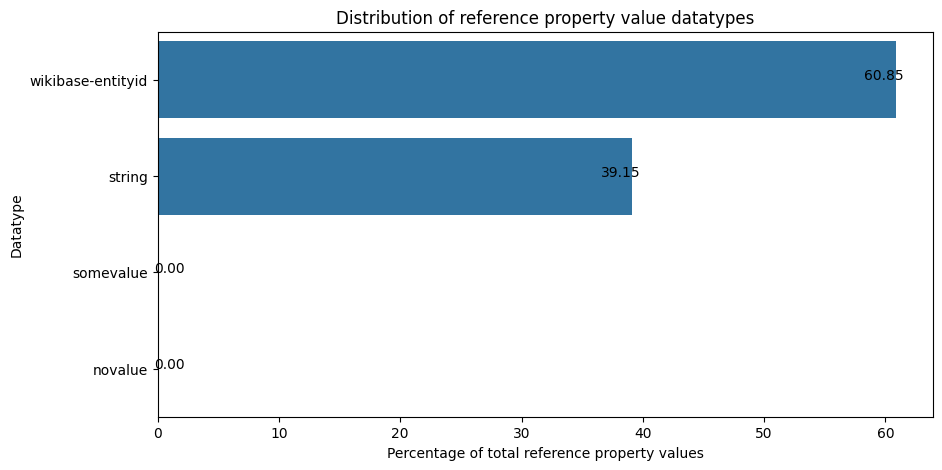

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



update = True  # set False if you just want to reload from CSV

if update:
    # Run the query directly in DuckDB
    ref_datatype_count = con.execute("""
        SELECT reference_datatype, COUNT(*) as count
        FROM refs
        GROUP BY reference_datatype
        ORDER BY count DESC
    """).df()

    # Save for later reuse
    ref_datatype_count.to_csv('data/ref_datatype_count.csv', index=False)
else:
    ref_datatype_count = pd.read_csv('data/ref_datatype_count.csv')

# Plot
fig, ax = plt.subplots(figsize=[10,5])

# Calculate percentages
percentages = ref_datatype_count['count'].apply(lambda x: 100 * x / ref_datatype_count['count'].sum())
labels = ref_datatype_count['reference_datatype']

# Barplot
ax = sns.barplot(y=labels, x=percentages, orient="h")
ax.set_title("Distribution of reference property value datatypes")
ax.set(ylabel='Datatype', xlabel='Percentage of total reference property values')

# Add value labels
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1 if width < 15 else width - 1,
            p.get_y() + p.get_height()/2.,
            '{:1.2f}'.format(width),
            ha="center")

plt.show()


In [22]:
from qwikidata.linked_data_interface import get_entity_dict_from_api
from urllib3.exceptions import MaxRetryError
from qwikidata.linked_data_interface import LdiResponseNotOk
import time

def get_entity(item_id):
    while True:
        try:
            entity = get_entity_dict_from_api(item_id)
            return entity
        except ConnectionError:
            #traceback.print_exc()
            continue
        except MaxRetryError:
            #traceback.print_exc()
            time.sleep(1)
        except LdiResponseNotOk:
            #traceback.print_exc()
            return 'deleted'

def get_label(item):
    if type(item) == str:        
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        labels = entity['labels']
    elif type(item) == dict:
        labels = item['labels']
    languages = ['en','fr','es','pt','pt-br','it','de']
    for l in languages:
        if l in labels:
            return labels[l]['value']
    return 'no-label'

def get_datatype(item):
    try:
        if type(item) == str:
            entity = get_entity(item)
            if entity == 'deleted':
                return entity
            datatype = entity['datatype']
        elif type(item) == dict:
            datatype = item['datatype']
        return datatype
    except KeyError:
        return 'none'

def get_claim_values_of(item, property_id):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        claims = entity['claims']
    elif type(item) == dict:
        claims = item['claims']
    if property_id in claims:
        instance_of_claims = claims[property_id]
        return [i['mainsnak']['datavalue']['value']['id'] for i in instance_of_claims]
    else:
        return []
    
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

# Stated in 

In [16]:
import re 
import requests
import time

# Simple cache to avoid duplicate requests
label_cache = {}

def get_item_label(item, retries=3, delay=0.5):
    if not re.match(r'^[QP][0-9]+$', str(item)):
        return str(item)

    # Check cache first
    if item in label_cache:
        return label_cache[item]

    url = f'https://www.wikidata.org/wiki/Special:EntityData/{item}.json'

    for attempt in range(retries):
        try:
            r = requests.get(url, timeout=10)
            r.raise_for_status()
            json_data = r.json()

            entity = json_data['entities'].get(item, {})
            labels = entity.get('labels', {})

            # Preferred language order
            for lang in ['en', 'de', 'es', 'fr', 'nl']:
                if lang in labels:
                    label_cache[item] = labels[lang]['value']
                    return label_cache[item]

            # If no preferred language exists, take the first available label
            if labels:
                first_label = next(iter(labels.values()))['value']
                label_cache[item] = first_label
                return first_label

            # Fallback: return QID itself
            label_cache[item] = item
            return item

        except Exception:
            # Wait a bit before retrying
            time.sleep(delay)

    # If all retries fail → return QID
    label_cache[item] = item
    return item

In [14]:
item = 'Q82494'
get_item_label(item)

'National Center for Biotechnology Information'

In [ ]:
# import pandas as pd

# update = True
# TOP_N = 500   # only label the 500 most frequent sources

# if update:
#     # Step 1: Get counts of P248 "stated in" references directly from DuckDB
#     stated_in_ids = con.execute(f"""
#         SELECT reference_value AS stated_in_id,
#                COUNT(*) AS count
#         FROM refs
#         WHERE reference_property_id = 'P248'
#           AND reference_value NOT IN ('novalue', 'somevalue')
#         GROUP BY stated_in_id
#         ORDER BY count DESC
#         LIMIT {TOP_N}
#     """).df()
    
#     # Step 2: Add label column
#     stated_in_ids['label'] = 'none'
    
#     # Step 3: Enrich only top-N with Wikidata API
#     total = stated_in_ids.shape[0]
#     for i in range(total):
#         print(f"{(i+1)/total*100:.2f}% done", end='\r')
#         if stated_in_ids.loc[i, 'label'] == 'none':
#             entity = get_entity(stated_in_ids.loc[i, 'stated_in_id'])
#             if isinstance(entity, str):
#                 stated_in_ids.loc[i, 'label'] = entity
#             elif isinstance(entity, dict):
#                 stated_in_ids.loc[i, 'label'] = str(get_label(entity))
    
#     # Step 4: Save to CSV
#     stated_in_ids.to_csv('data/stated_in_refs_df.csv', index=False)

# else:
#     stated_in_ids = pd.read_csv('data/stated_in_refs_df.csv').fillna('')

# stated_in_ids


,stated_in_id,count,label
0,Q5412157,411275689,Europe PubMed Central
1,Q5188229,160077236,no-label
2,Q229883,123511103,no-label
3,Q180686,61229426,no-label
4,Q654724,46367656,SIMBAD
...,...,...,...
495,Q106917282,44702,deleted
496,Q22679902,44591,deleted
497,Q57768257,44479,deleted
498,Q133805362,44382,deleted


In [17]:
import pandas as pd

# Load the CSV
stated_in_ids = pd.read_csv("data/stated_in_refs_df.csv")

# Add a new column for resolved labels
stated_in_ids["label_2"] = ""

total = len(stated_in_ids)
for i in range(total):
    qid = stated_in_ids.loc[i, "stated_in_id"]
    qid = str(qid)
    label = get_item_label(qid)
    print(label)
    # Ensure it's a string
    # if not isinstance(label, str):
    #     label = str(label)

    stated_in_ids.loc[i, "label_2"] = label
    
    # progress bar
    if (i+1) % 10 == 0 or i == total-1:
        print(f"{i+1}/{total} ({(i+1)/total*100:.2f}%) done", end="\r")

# Save back to CSV
stated_in_ids.to_csv("data/stated_in_refs_df_with_labels.csv", index=False)

print("✅ Finished! File saved as data/stated_in_refs_df_with_labels.csv")


Europe PubMed Central
CrossRef
پاب‌مد سنترال
الطب للعموم
SIMBAD
April 2024 Public Data File from Crossref
Gaia Data Release 2
CNKI
جينيدب
VizieR Online Data Catalog: 2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)
NCBI జన్యు సమాచారము
National Center for Biotechnology Information
Fichero de Autoridades Virtual Internacional
The Tycho-2 catalogue of the 2.5 million brightest stars
GEOnet Names Server
The SDSS Photometric Catalog, Release 7
Czech National Authority Database
GOA
COCI
Global Biodiversity Information Facility
The Peerage0%) done
УниПрот
Gaia Data Release 1. Summary of the astrometric, photometric, and survey properties
National Catalog of Museum Collections
SIRENE
Wiki Loves Monuments monuments database
Geographic Names Information System
Czech National Bibliography
JPL Small-Body Database
April 2022 Public Data File from Crossref
China Biographical Database
HYPERLEDA. I. Identification and designation of galaxies
National Heritage List for England
Steam
Open Tree of Li

/tmp/ipykernel_701524/1053137803.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=percentages, orient="h", ax=ax,palette="Spectral")
/home/msadek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3100 (\N{TELUGU LETTER JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/msadek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/msadek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3112 (\N{TELUGU LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/msadek/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3149 

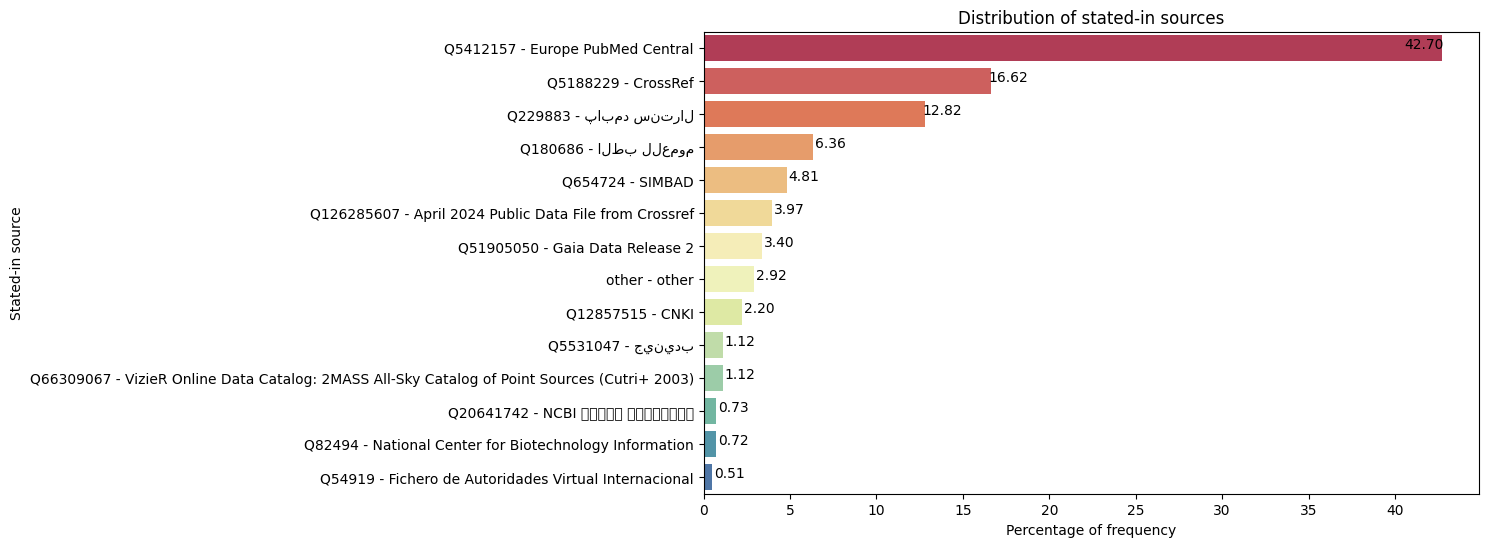

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stated_in_distribution(csv_path, TOP_N=500, other_thr=None):
    """
    Plot distribution of stated-in sources.

    Parameters
    ----------
    csv_path : str
        Path to CSV with columns ['stated_in_id','count','label'].
    TOP_N : int
        Number of top sources to keep before plotting.
    other_thr : float or None
        Percentage threshold for grouping into 'other'. Example: 0.5 means <0.5% go to 'other'.
        If None, no 'other' grouping is done.
    """
    # Load the file
    df = pd.read_csv(csv_path)

    # Restrict to TOP_N
    df = df.nlargest(TOP_N, "count").reset_index(drop=True)

    # Compute percentages
    total_count = df['count'].sum()
    df['per'] = df['count'].apply(lambda x: 100 * x / total_count)

    if other_thr is not None:
        # Group sources below threshold into "other"
        other_row = df[df['per'] < other_thr].sum(numeric_only=True)
        other_row['stated_in_id'] = 'other'
        other_row['label_2'] = 'other'
        other_row['per'] = 100 * other_row['count'] / total_count

        # Keep only above threshold + add "other"
        df = pd.concat(
            [df[df['per'] >= other_thr], pd.DataFrame([other_row])],
            ignore_index=True
        ).sort_values('per', ascending=False).reset_index(drop=True)

    # Plot
    fig, ax = plt.subplots(figsize=[10, 6])
    labels = df.apply(lambda x: f"{x['stated_in_id']} - {x['label_2']}", axis=1)
    percentages = df['per']

    sns.barplot(y=labels, x=percentages, orient="h", ax=ax,palette="Spectral")
    ax.set_title("Distribution of stated-in sources")
    ax.set(ylabel="Stated-in source", xlabel="Percentage of frequency")

    # Add percentage values on bars
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 1 if width < 20 else width - 1,
                p.get_y() + p.get_height()/2.,
                f"{width:.2f}",
                ha="center")

    plt.show()

# Example usage:
# Plot top 20 sources, group the rest (<1%) as "other"
plot_stated_in_distribution("data/stated_in_refs_df_with_labels.csv", TOP_N=20, other_thr=0.5)

# Or plot top 500 without grouping
# plot_stated_in_distribution("data/stated_in_refs_df.csv", TOP_N=500, other_thr=None)


In [30]:
if update:
    # Load your current file with stated_in_id + count + label
    stated_in_ids = pd.read_csv("data/stated_in_refs_df.csv").fillna('')

    # Initialize empty columns if not present
    if 'instance_of' not in stated_in_ids.columns:
        stated_in_ids['instance_of'] = 'none'
    if 'subclass_of' not in stated_in_ids.columns:
        stated_in_ids['subclass_of'] = 'none'

    total = stated_in_ids.shape[0]

    for i in range(total):
        print(f"{(i+1)/total*100:.2f}% done", end='\r')

        if 'none' in list(stated_in_ids.loc[i, ['instance_of', 'subclass_of']]):
            qid = stated_in_ids.loc[i, 'stated_in_id']
            entity = get_entity(qid)

            if isinstance(entity, dict):
                stated_in_ids.loc[i, 'instance_of'] = ','.join(get_claim_values_of(entity, 'P31'))
                stated_in_ids.loc[i, 'subclass_of'] = ','.join(get_claim_values_of(entity, 'P279'))
            else:
                stated_in_ids.loc[i, 'instance_of'] = ''
                stated_in_ids.loc[i, 'subclass_of'] = ''

    # Save enriched file
    stated_in_ids.to_csv("data/stated_in_refs_df_v2.csv", index=False)

In [23]:
def label_first_qid(qid_string):
    """Take 'Q1789476,Q1916557' and return the label of the first QID only."""
    if not qid_string or qid_string in ['none', 'nan']:
        return ''
    first_qid = str(qid_string).split(',')[0].strip()
    return get_item_label(first_qid)

# Load your data
stated_in_ids = pd.read_csv("data/stated_in_refs_df_v2.csv").fillna('')

# Apply only first instance_of QID
stated_in_ids['label_instance_of'] = stated_in_ids['instance_of'].apply(label_first_qid)

# Save to new file
stated_in_ids.to_csv("data/stated_in_refs_with_instance_labels.csv", index=False)

# Preview
stated_in_ids[['stated_in_id','instance_of','label_instance_of']].head(10)

,stated_in_id,instance_of,label_instance_of
0,Q5412157,"Q1789476,Q1916557,Q4117139",bibliographic database
1,Q5188229,"Q1789476,Q352450,Q108934881",bibliographic database
2,Q229883,"Q212805,Q1789476,Q1916557,Q7096323",digital library
3,Q180686,"Q35127,Q19541,Q1916557,Q1789476,Q8513",website
4,Q654724,"Q2352616,Q8513",catalogue
5,Q126285607,Q3331189,"version, edition or translation"
6,Q51905050,"Q850950,Q550089,Q13442814",star catalogue
7,Q12857515,"Q1789476,Q2532732,Q35127,Q43229,Q126004556",bibliographic database
8,Q5531047,Q4117139,biological database
9,Q66309067,"Q850950,Q13442814",star catalogue


In [24]:
def get_first_qid(qid_string):
    """Take 'Q1789476,Q1916557' and return the label of the first QID only."""
    if not qid_string or qid_string in ['none', 'nan']:
        return ''
    first_qid = str(qid_string).split(',')[0].strip()
    return first_qid

# Stated In Classes 

/tmp/ipykernel_701524/2853790008.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=percentages, ax=ax, orient="h", palette="Spectral",errorbar=None)


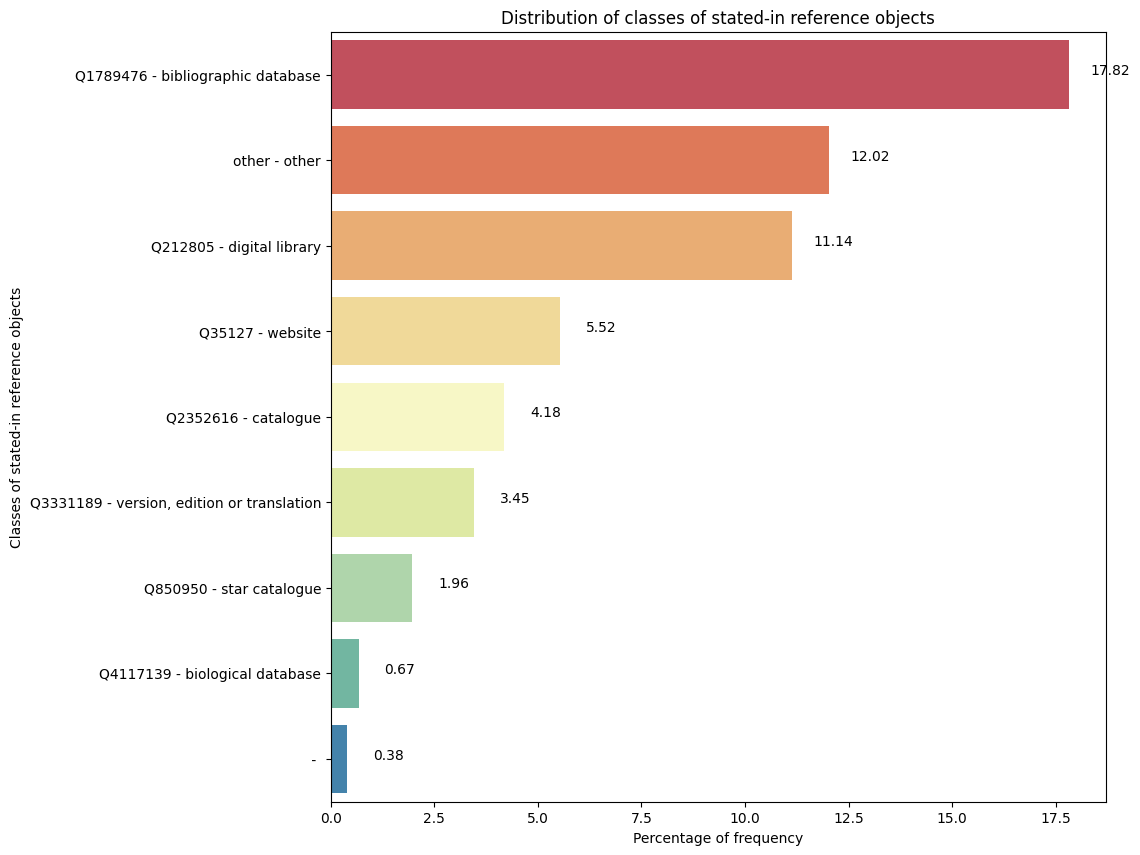

In [25]:

stated_in_ids_instance_of = stated_in_ids.copy()

# --- Apply threshold ---
other_thr = 0.25  # percentage threshold
total_count = stated_in_ids_instance_of['count'].sum()
stated_in_ids_instance_of['per'] = stated_in_ids_instance_of['count'] * 100 / total_count

# Aggregate small ones into "other"
other_row = stated_in_ids_instance_of[stated_in_ids_instance_of['per'] < other_thr].sum(numeric_only=True)
other_row['instance_of'] = 'other'
other_row['label_instance_of'] = 'other'
other_row['per'] = 100 * other_row['count'] / total_count

# Concatenate and filter
stated_in_ids_instance_of_c = pd.concat(
    [stated_in_ids_instance_of[stated_in_ids_instance_of['per'] >= other_thr],
     pd.DataFrame([other_row])]
).sort_values('per', ascending=False).reset_index(drop=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
labels = stated_in_ids_instance_of_c.apply(
    lambda x: f"{get_first_qid(x['instance_of'])} - {x['label_instance_of']}", 
    axis=1
)
percentages = stated_in_ids_instance_of_c['per']

sns.barplot(y=labels, x=percentages, ax=ax, orient="h", palette="Spectral",errorbar=None)
ax.set_title("Distribution of classes of stated-in reference objects")
ax.set(ylabel="Classes of stated-in reference objects", xlabel="Percentage of frequency")

# Add values on bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1 if width < 20 else width - 1,
            p.get_y() + p.get_height() / 2.,
            f"{width:.2f}",
            ha="center")

plt.show()


In [26]:
def explode_instance_of(df):
    """
    Explodes the instance_of column so each QID is on its own row.
    Keeps stated_in_id and count duplicated across exploded rows.
    """
    df = df.copy()
    df['instance_of'] = df['instance_of'].astype(str).str.split(',')
    df_exploded = df.explode('instance_of').reset_index(drop=True)
    df_exploded['instance_of_expanded'] = df_exploded['instance_of'].str.strip()
    return df_exploded

In [27]:
# Load your enriched dataset
stated_in_ids = pd.read_csv("data/stated_in_refs_df_v2.csv").fillna('')

# Explode instance_of into multiple rows
stated_in_ids_exploded = explode_instance_of(stated_in_ids)

# Resolve labels
stated_in_ids_exploded['label_instance_of'] = stated_in_ids_exploded['instance_of_expanded'].apply(get_item_label)

# Save
stated_in_ids_exploded.to_csv("data/stated_in_refs_instance_exploded.csv", index=False)

# Preview
stated_in_ids_exploded.head(10)

,stated_in_id,count,label,instance_of,subclass_of,instance_of_expanded,label_instance_of
0,Q5412157,411275689,Europe PubMed Central,Q1789476,,Q1789476,bibliographic database
1,Q5412157,411275689,Europe PubMed Central,Q1916557,,Q1916557,medical database
2,Q5412157,411275689,Europe PubMed Central,Q4117139,,Q4117139,biological database
3,Q5188229,160077236,no-label,Q1789476,,Q1789476,bibliographic database
4,Q5188229,160077236,no-label,Q352450,,Q352450,agency
5,Q5188229,160077236,no-label,Q108934881,,Q108934881,open science infrastructure
6,Q229883,123511103,no-label,Q212805,,Q212805,digital library
7,Q229883,123511103,no-label,Q1789476,,Q1789476,bibliographic database
8,Q229883,123511103,no-label,Q1916557,,Q1916557,medical database
9,Q229883,123511103,no-label,Q7096323,,Q7096323,open-access repository


/tmp/ipykernel_701524/2451019749.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


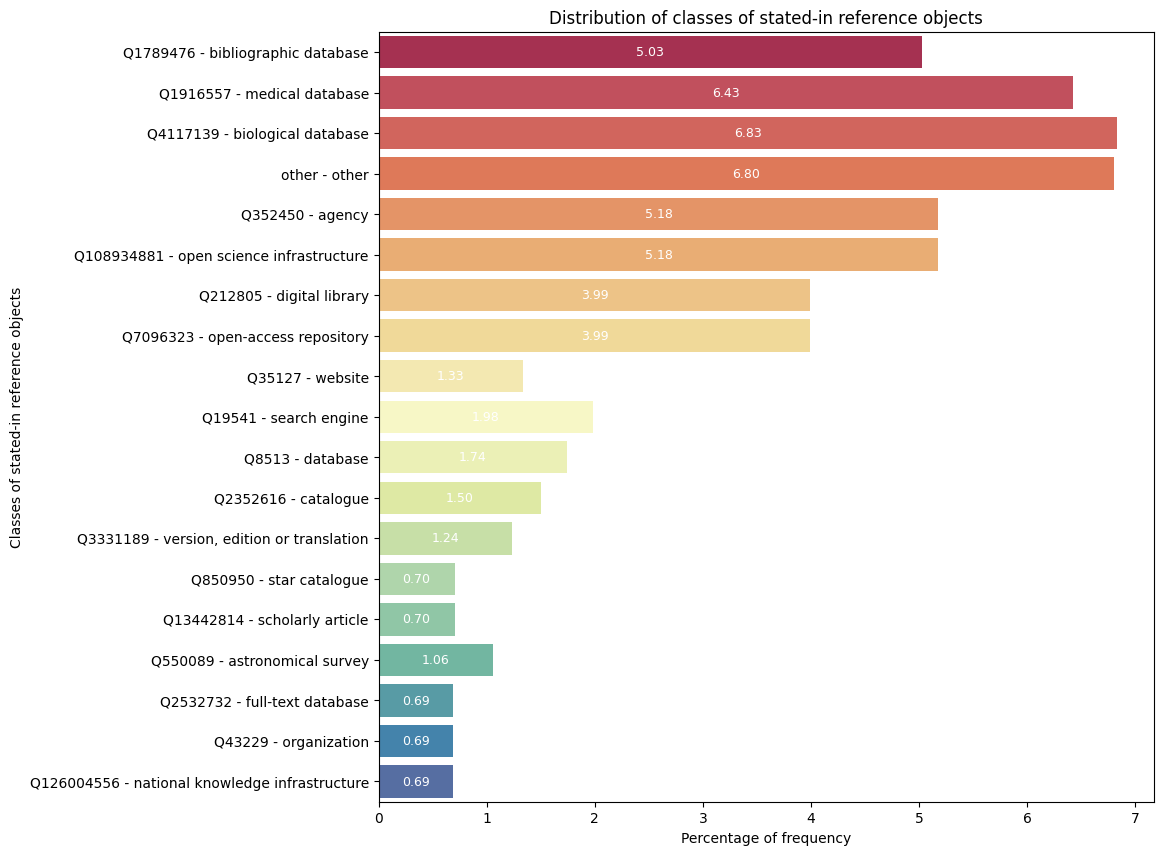

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copy exploded df
stated_in_ids_instance_of_c = stated_in_ids_exploded.copy()

# --- Apply threshold ---
other_thr = 0.25  # percentage threshold
total_count = stated_in_ids_instance_of_c['count'].sum()
stated_in_ids_instance_of_c['per'] = stated_in_ids_instance_of_c['count'] * 100 / total_count

# Aggregate small ones into "other"
other_row = stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] < other_thr].sum(numeric_only=True)
other_row['instance_of'] = 'other'
other_row['label_instance_of'] = 'other'
other_row['per'] = 100 * other_row['count'] / total_count

# Concatenate and sort
stated_in_ids_instance_of_c = pd.concat(
    [stated_in_ids_instance_of_c[stated_in_ids_instance_of_c['per'] >= other_thr],
     pd.DataFrame([other_row])],
    ignore_index=True
).sort_values('per', ascending=False).reset_index(drop=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
labels = stated_in_ids_instance_of_c.apply(
    lambda x: f"{x['instance_of']} - {x['label_instance_of']}", axis=1
)
percentages = stated_in_ids_instance_of_c['per']

sns.barplot(
    y=labels,
    x=percentages,
    ax=ax,
    orient="h",
    palette="Spectral",
    errorbar=None
)

ax.set_title("Distribution of classes of stated-in reference objects")
ax.set(ylabel="Classes of stated-in reference objects", xlabel="Percentage of frequency")

# Add percentages on bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width/2,  # put text in the middle of the bar
            p.get_y() + p.get_height()/2.,
            f"{width:.2f}",
            ha="center", va="center", color="white", fontsize=9)


plt.show()


# Reference URL P854

In [14]:
import pandas as pd
import tldextract
from urllib.parse import urlparse

update = True  # change to False if you want to load from CSV

if update:
    # Query P854 reference URLs from refs view
    reference_urls = con.execute("""
        SELECT reference_value AS reference_url
        FROM refs
        WHERE reference_property_id = 'P854'
          AND reference_value NOT IN ('novalue','somevalue')
    """).df()

    # Count frequency of each URL
    reference_urls['count'] = 1
    reference_urls = (
        reference_urls.groupby('reference_url')
        .sum()
        .sort_values('count', ascending=False)
        .reset_index()
    )




In [15]:
reference_urls

,reference_url,count
0,https://data.gov.in/resources/all-india-pincod...,769305
1,http://schoolgis.nic.in/,624111
2,http://dati.istruzione.it/opendata/opendata/ca...,523553
3,https://www.tuik.gov.tr,387136
4,https://html.spec.whatwg.org/multipage/syntax....,328180
...,...,...
75016606,https://api.crossref.org/works/10.1155%2F2017%...,1
75016607,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,1
75016608,https://api.crossref.org/works/10.1155%2F2017%...,1
75016609,https://api.crossref.org/works/10.1155%2F2017%...,1


In [16]:
reference_urls.to_csv('data/reference_urls_df.csv', index=False)


In [17]:
# Extract domain components
domains_df = reference_urls['reference_url'].apply(tldextract.extract)
domains_df = pd.DataFrame(domains_df.tolist(), index=domains_df.index, 
                          columns=['subdomain','domain','suffix'])
reference_urls[['subdomain','domain','suffix']] = domains_df

# Parse full URL structure
urlparse_df = reference_urls['reference_url'].apply(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
reference_urls[['scheme','netloc','path','params','query','fragment']] = urlparse_df

# Save for later
reference_urls.to_csv('data/reference_urls_all_df.csv', index=False)


In [18]:
reference_urls

,reference_url,count,subdomain,domain,suffix,scheme,netloc,path,params,query,fragment
0,https://data.gov.in/resources/all-india-pincod...,769305,,data,gov.in,https,data.gov.in,/resources/all-india-pincode-directory-contact...,,,
1,http://schoolgis.nic.in/,624111,,schoolgis,nic.in,http,schoolgis.nic.in,/,,,
2,http://dati.istruzione.it/opendata/opendata/ca...,523553,dati,istruzione,it,http,dati.istruzione.it,/opendata/opendata/catalogo/elements1/,,area=Scuole,
3,https://www.tuik.gov.tr,387136,www,tuik,gov.tr,https,www.tuik.gov.tr,,,,
4,https://html.spec.whatwg.org/multipage/syntax....,328180,html.spec,whatwg,org,https,html.spec.whatwg.org,/multipage/syntax.html,,,character-references
...,...,...,...,...,...,...,...,...,...,...,...
75016606,https://api.crossref.org/works/10.1155%2F2017%...,1,api,crossref,org,https,api.crossref.org,/works/10.1155%2F2017%2F7406959,,,
75016607,https://eutils.ncbi.nlm.nih.gov/entrez/eutils/...,1,eutils.ncbi.nlm,nih,gov,https,eutils.ncbi.nlm.nih.gov,/entrez/eutils/esummary.fcgi,,db=pubmed&retmode=json&id=537648,
75016608,https://api.crossref.org/works/10.1155%2F2017%...,1,api,crossref,org,https,api.crossref.org,/works/10.1155%2F2017%2F7404289,,,
75016609,https://api.crossref.org/works/10.1155%2F2017%...,1,api,crossref,org,https,api.crossref.org,/works/10.1155%2F2017%2F7403747,,,


There are 467692 unique domains.


/tmp/ipykernel_714004/2565356113.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


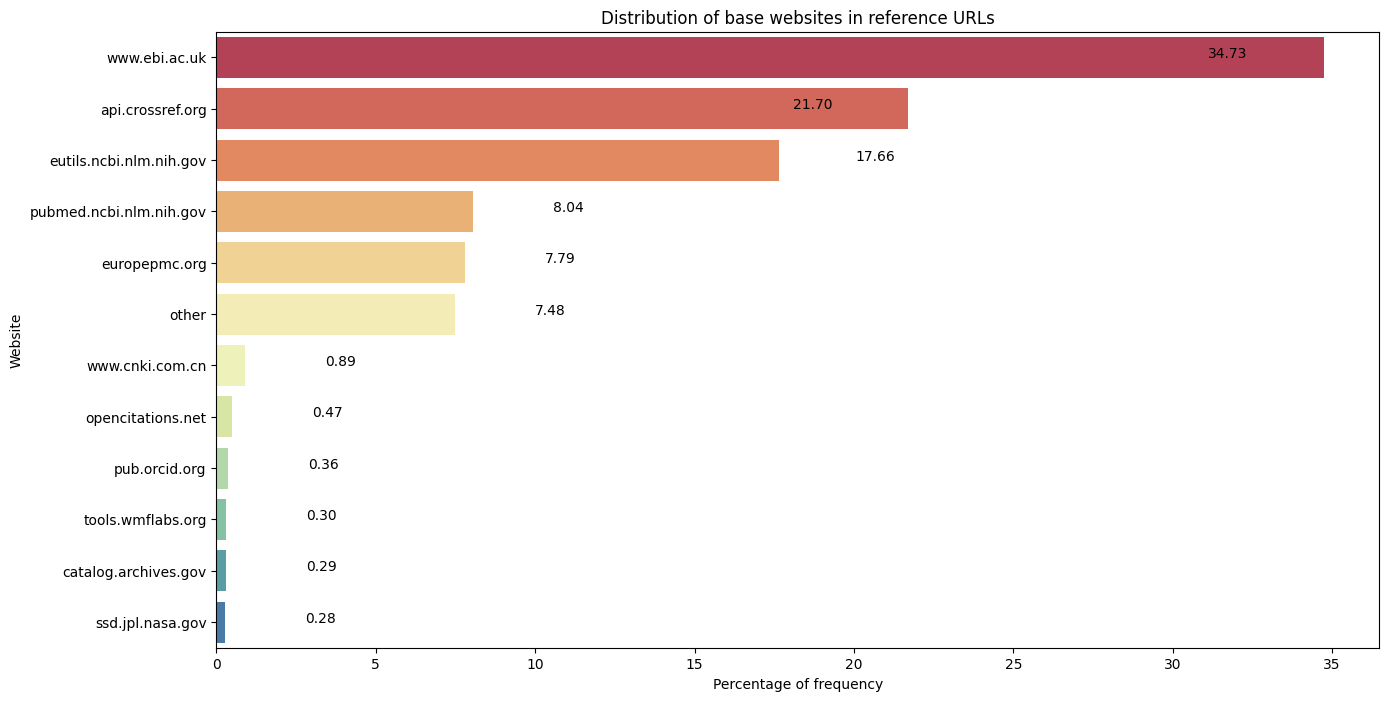

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregate by netloc
netlocs_df = (
    reference_urls[['netloc','count']]
    .groupby('netloc')
    .sum()
    .sort_values('count', ascending=False)
    .reset_index()
)

print(f"There are {netlocs_df.shape[0]} unique domains.")

# 2. Compute percentages
total_count = netlocs_df['count'].sum()
netlocs_df['per'] = netlocs_df['count'] * 100 / total_count

# 3. Aggregate "other" below threshold (0.25%)
other_thr = 0.25
other_row = netlocs_df[netlocs_df['per'] < other_thr].sum(numeric_only=True)
other_row['netloc'] = 'other'
other_row['per'] = 100 * other_row['count'] / total_count

netlocs_df_agg = pd.concat(
    [netlocs_df[netlocs_df['per'] >= other_thr], pd.DataFrame([other_row])],
    ignore_index=True
).sort_values('per', ascending=False).reset_index(drop=True)

# 4. Plot
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(
    y='netloc', 
    x='per', 
    data=netlocs_df_agg, 
    ax=ax,
    palette="Spectral",
    errorbar=None
)

ax.set_title("Distribution of base websites in reference URLs")
ax.set(ylabel="Website", xlabel="Percentage of frequency")

# 5. Add percentages on bars
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 3 if width < 20 else width - 3,
        p.get_y() + p.get_height()/2.,
        f"{width:.2f}",
        ha="center"
    )

plt.show()


/tmp/ipykernel_714004/2266781962.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y='suffix', x='per', data=suffix_df_agg, ax=ax[0], palette="Spectral", errorbar=None)
/tmp/ipykernel_714004/2266781962.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(y='end', x='per', data=suffix_end_df_agg, ax=ax[1], palette="Spectral", errorbar=None)


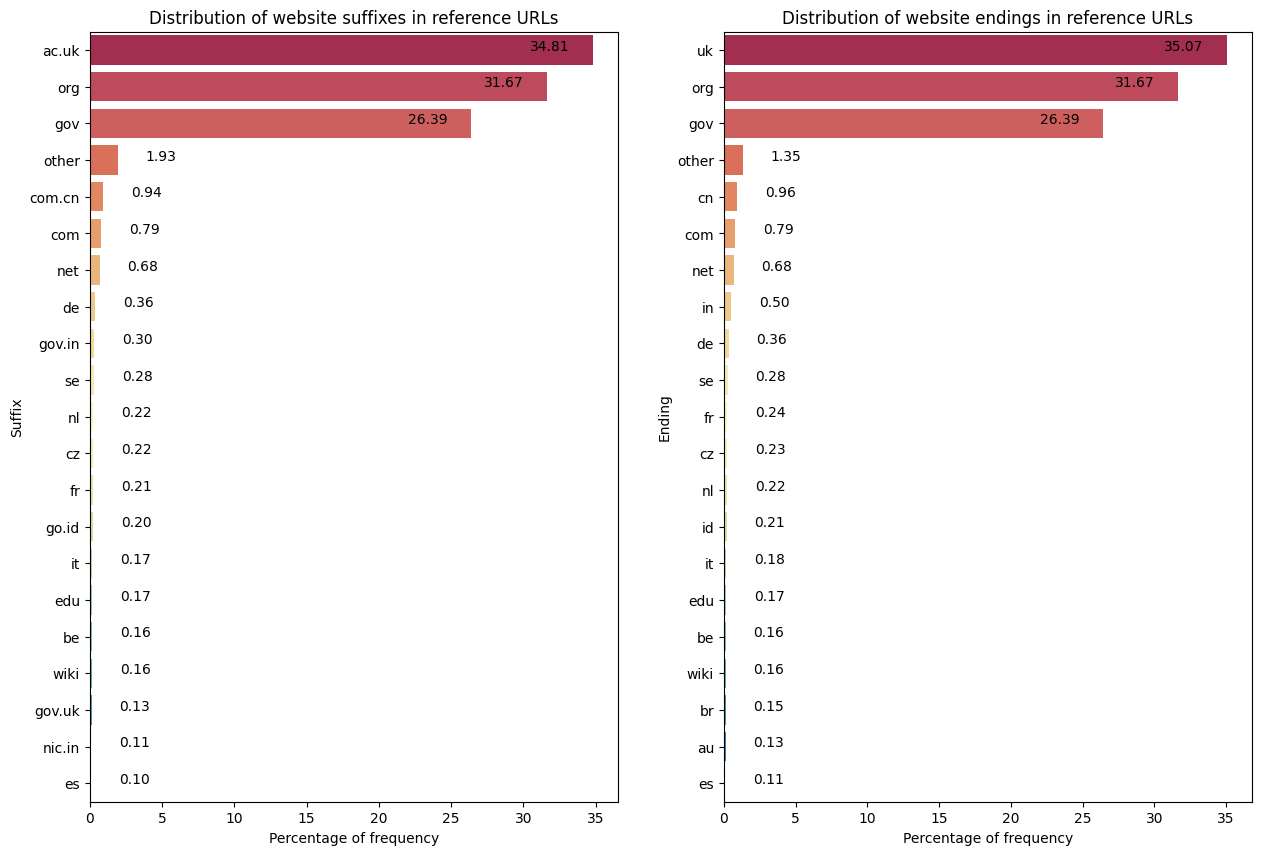

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Group by suffix (full suffix, e.g. "gov.in", "co.uk")
suffix_df = (
    reference_urls[['suffix','count']]
    .groupby('suffix')
    .sum()
    .sort_values('count', ascending=False)
    .reset_index()
)

# Add column with only the last part of suffix (e.g., "in", "uk", "org")
suffix_df['end'] = suffix_df['suffix'].astype(str).apply(lambda x: x.split('.')[-1])

# Compute percentages
total_count = suffix_df['count'].sum()
suffix_df['per'] = suffix_df['count'] * 100 / total_count

# --- Aggregate small suffixes into "other"
other_thr = 0.1  # threshold in percentage
other_row = suffix_df[suffix_df['per'] < other_thr].sum(numeric_only=True)
other_row['suffix'] = 'other'
other_row['end'] = 'other'
other_row['per'] = 100 * other_row['count'] / total_count

suffix_df_agg = pd.concat(
    [suffix_df[suffix_df['per'] >= other_thr], pd.DataFrame([other_row])],
    ignore_index=True
).sort_values('per', ascending=False).reset_index(drop=True)

# --- Same for suffix endings
suffix_end_df = (
    suffix_df[['end','count']]
    .groupby('end')
    .sum()
    .sort_values('count', ascending=False)
    .reset_index()
)
suffix_end_df['per'] = suffix_end_df['count'] * 100 / suffix_end_df['count'].sum()

other_row_end = suffix_end_df[suffix_end_df['per'] < other_thr].sum(numeric_only=True)
other_row_end['end'] = 'other'
other_row_end['per'] = 100 * other_row_end['count'] / suffix_end_df['count'].sum()

suffix_end_df_agg = pd.concat(
    [suffix_end_df[suffix_end_df['per'] >= other_thr], pd.DataFrame([other_row_end])],
    ignore_index=True
).sort_values('per', ascending=False).reset_index(drop=True)

# --- Plot both side by side
fig, ax = plt.subplots(1, 2, figsize=[15, 10])

# Full suffix (e.g., gov.in, co.uk)
g = sns.barplot(y='suffix', x='per', data=suffix_df_agg, ax=ax[0], palette="Spectral", errorbar=None)
g.set_title("Distribution of website suffixes in reference URLs")
g.set(ylabel="Suffix", xlabel="Percentage of frequency")

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3,
           p.get_y() + p.get_height()/2.,
           f"{width:.2f}",
           ha="center")

# Endings (e.g., org, com, in)
g = sns.barplot(y='end', x='per', data=suffix_end_df_agg, ax=ax[1], palette="Spectral", errorbar=None)
g.set_title("Distribution of website endings in reference URLs")
g.set(ylabel="Ending", xlabel="Percentage of frequency")

for p in g.patches:
    width = p.get_width()
    g.text(width + 3 if width < 20 else width - 3,
           p.get_y() + p.get_height()/2.,
           f"{width:.2f}",
           ha="center")

plt.show()


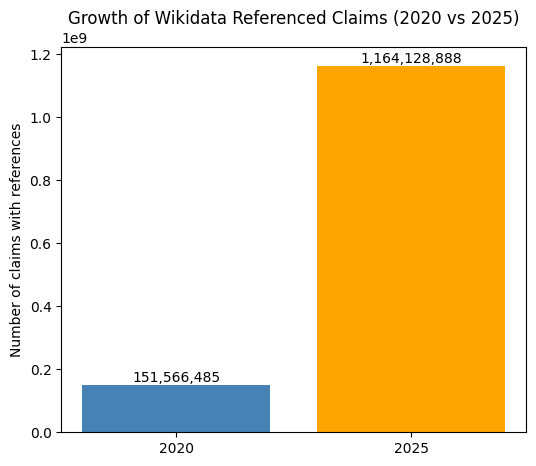

In [22]:
import matplotlib.pyplot as plt

# Data
years = ["2020", "2025"]
values = [151566485, 1164128888]  # claims with references

# Plot
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.bar(years, values, color=["steelblue", "orange"])

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f"{height:,}", ha="center", va="bottom", fontsize=10)

# Labels and title
ax.set_ylabel("Number of claims with references")
ax.set_title("Growth of Wikidata Referenced Claims (2020 vs 2025)")

plt.show()